# Detecting COVID-19 with Chest X Ray using PyTorch


# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using PyTorch version 2.6.0+cu124
Using device: cuda


# Preparing Training and Test Sets

In [2]:
!pip install kaggle

In [3]:
import os
# Replace the below credentials with your own.
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 770M/778M [00:04<00:00, 111MB/s] 
100% 778M/778M [00:04<00:00, 188MB/s]


In [5]:
!unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [6]:
import random
import shutil

class_names = ['normal', 'viral', 'covid', 'lung_opacity']
root_dir = '/content/COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.makedirs(os.path.join(root_dir, 'test'), exist_ok=True)

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.makedirs(os.path.join(root_dir, 'test', c), exist_ok=True)

    # Move 30 random images from each class's images/ folder to test/
    for c in class_names:
        image_dir = os.path.join(root_dir, c, 'images')
        test_class_dir = os.path.join(root_dir, 'test', c)

        images = [x for x in os.listdir(image_dir) if x.lower().endswith('.png')]
        k = min(30, len(images))
        selected_images = random.sample(images, k)

        for image in selected_images:
            source_path = os.path.join(image_dir, image)
            target_path = os.path.join(test_class_dir, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [7]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform, has_images_subdir=True):
        def get_images(class_name):
            base_path = os.path.join(image_dirs[class_name], 'images') if has_images_subdir else image_dirs[class_name]
            images = [x for x in os.listdir(base_path) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid', 'lung_opacity']
        self.image_dirs = image_dirs
        self.transform = transform
        self.has_images_subdir = has_images_subdir

        for c in self.class_names:
            self.images[c] = get_images(c)

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])

        image_name = self.images[class_name][index]
        base_path = os.path.join(self.image_dirs[class_name], 'images') if self.has_images_subdir else self.image_dirs[class_name]
        image_path = os.path.join(base_path, image_name)

        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [8]:
# For RESNET
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [9]:
train_dirs = {
    'normal': '/content/COVID-19_Radiography_Dataset/normal',
    'viral': '/content/COVID-19_Radiography_Dataset/viral',
    'covid': '/content/COVID-19_Radiography_Dataset/covid',
    'lung_opacity': '/content/COVID-19_Radiography_Dataset/lung_opacity'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform, has_images_subdir=True)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples
Found 5982 lung_opacity examples


In [10]:
test_dirs = {
    'normal': '/content/COVID-19_Radiography_Dataset/test/normal',
    'viral': '/content/COVID-19_Radiography_Dataset/test/viral',
    'covid': '/content/COVID-19_Radiography_Dataset/test/covid',
    'lung_opacity': '/content/COVID-19_Radiography_Dataset/test/lung_opacity'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform, has_images_subdir=False)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples
Found 30 lung_opacity examples


In [11]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

print("Number of training batches", len(dl_train))
print("Number of testing batches", len(dl_test))

Number of training batches 3508
Number of testing batches 20


# Data Visualization

In [12]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))

    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])

        image = image.numpy().transpose((1, 2, 0))

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        image = image * std + mean
        image = np.clip(image, 0., 1.)

        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)

    plt.tight_layout()
    plt.show()

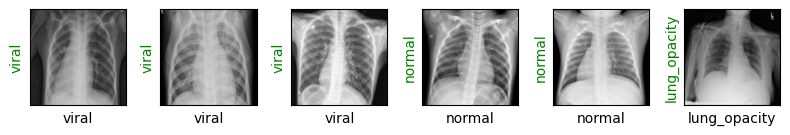

In [13]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

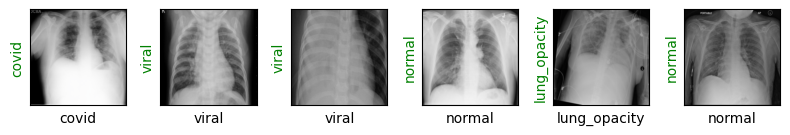

In [14]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [15]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [17]:
resnet18 = resnet18.to(device)

In [18]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)

    # Move to CPU for visualization
    show_images(images.cpu(), labels.cpu(), preds.cpu())

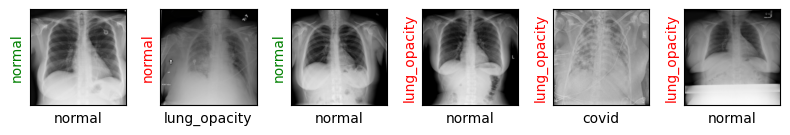

In [19]:
show_preds()

# Training the Model

In [20]:
def train(epochs):
    print("Starting training..")
    for e in range(0, epochs):
        print('-'*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('-'*20)

        train_loss = 0
        resnet18.train()

        for train_step, (images, labels) in enumerate(dl_train):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()

                with torch.no_grad():
                  for val_step, (images, labels) in enumerate(dl_test):
                      images = images.to(device)
                      labels = labels.to(device)

                      outputs = resnet18(images)
                      loss = loss_fn(outputs, labels)
                      val_loss += loss.item()

                      _, preds = torch.max(outputs, 1)
                      acc += torch.sum(preds == labels).item()

                  val_loss /= (val_step + 1)
                  acc = acc / len(test_dataset)

                  print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                  show_preds()

                resnet18.train()

                if acc > 0.98:
                    print('Performance condition satisfied..')
                    return

        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')

Starting training..
--------------------
Starting epoch 1/10
--------------------
Evaluating at step 0
Val loss: 1.3504, Acc: 0.3083


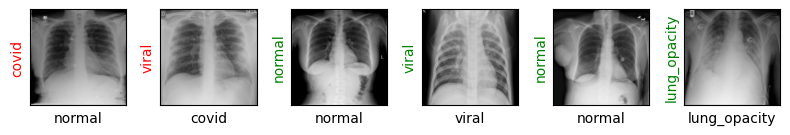

Evaluating at step 20
Val loss: 1.0677, Acc: 0.5667


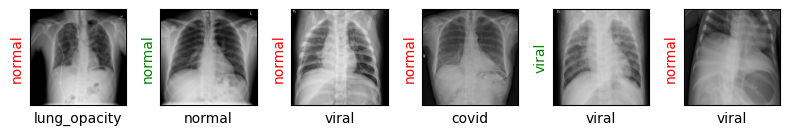

Evaluating at step 40
Val loss: 0.8210, Acc: 0.6500


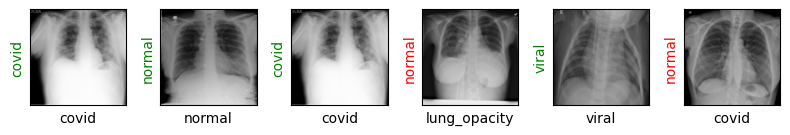

Evaluating at step 60
Val loss: 0.5236, Acc: 0.8500


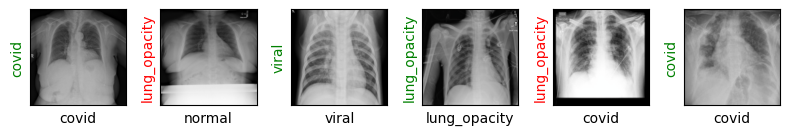

Evaluating at step 80
Val loss: 0.5195, Acc: 0.8500


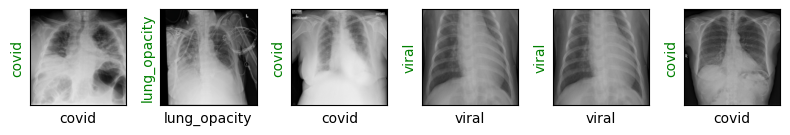

Evaluating at step 100
Val loss: 0.3901, Acc: 0.8917


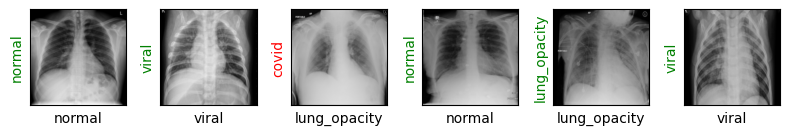

Evaluating at step 120
Val loss: 0.4310, Acc: 0.8667


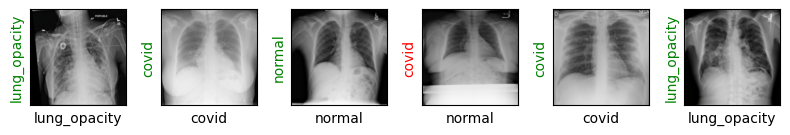

Evaluating at step 140
Val loss: 0.3936, Acc: 0.8917


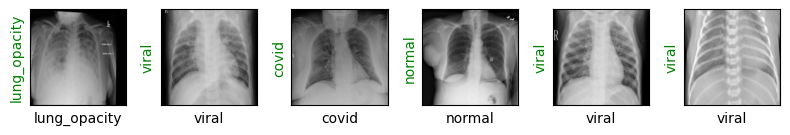

Evaluating at step 160
Val loss: 0.3939, Acc: 0.8750


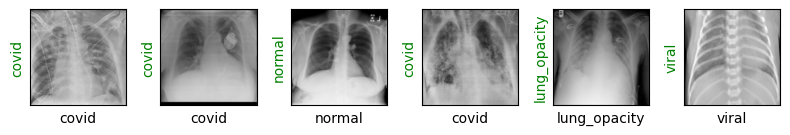

Evaluating at step 180
Val loss: 0.3831, Acc: 0.8917


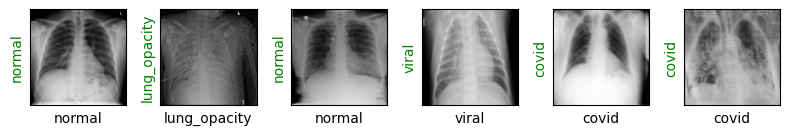

Evaluating at step 200
Val loss: 0.3218, Acc: 0.9000


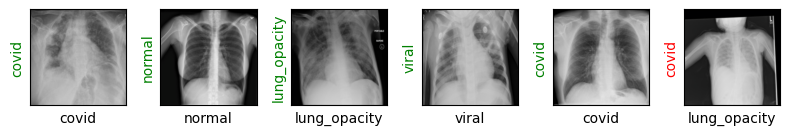

Evaluating at step 220
Val loss: 0.4592, Acc: 0.8500


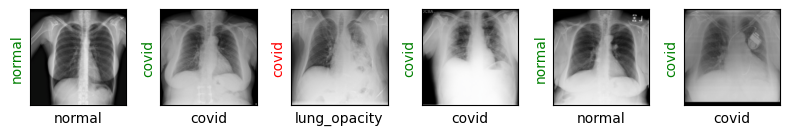

Evaluating at step 240
Val loss: 0.4291, Acc: 0.8750


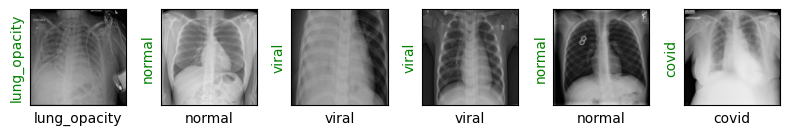

Evaluating at step 260
Val loss: 0.3244, Acc: 0.8500


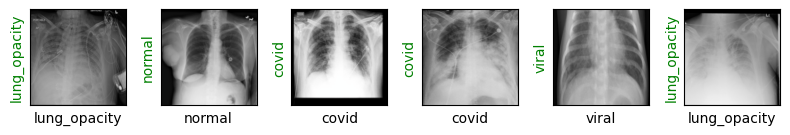

Evaluating at step 280
Val loss: 0.3531, Acc: 0.8750


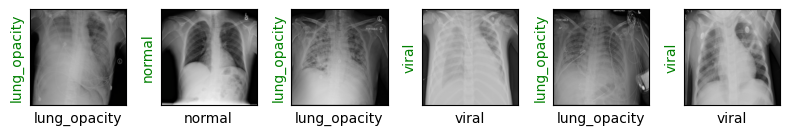

Evaluating at step 300
Val loss: 0.2288, Acc: 0.9417


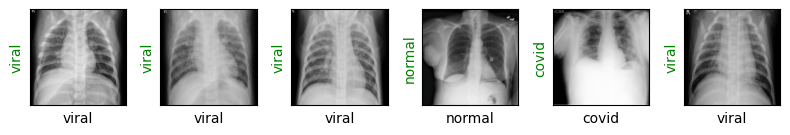

Evaluating at step 320
Val loss: 0.3249, Acc: 0.8750


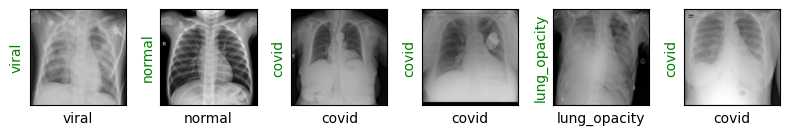

Evaluating at step 340
Val loss: 0.2826, Acc: 0.9000


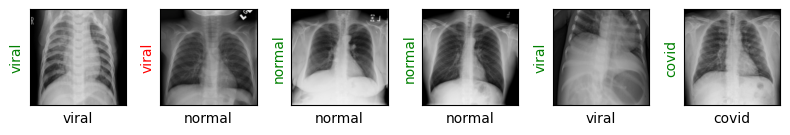

Evaluating at step 360
Val loss: 0.3772, Acc: 0.8333


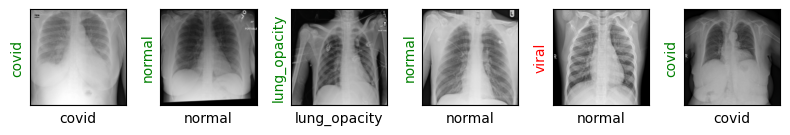

Evaluating at step 380
Val loss: 0.2854, Acc: 0.9000


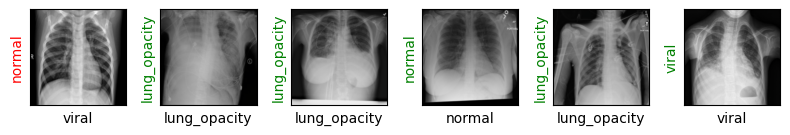

Evaluating at step 400
Val loss: 0.1901, Acc: 0.9333


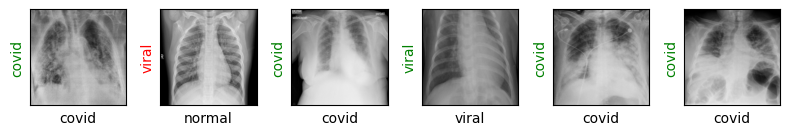

Evaluating at step 420
Val loss: 0.2629, Acc: 0.8917


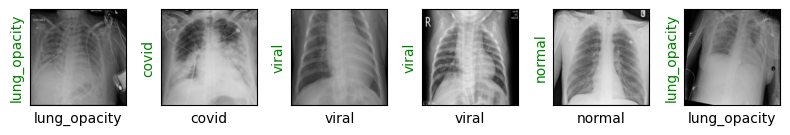

Evaluating at step 440
Val loss: 0.2327, Acc: 0.9333


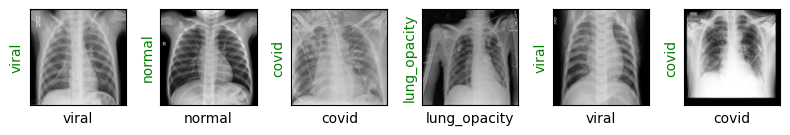

Evaluating at step 460
Val loss: 0.2481, Acc: 0.9000


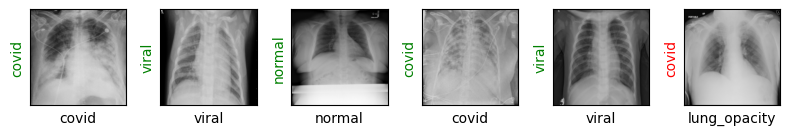

Evaluating at step 480
Val loss: 0.1928, Acc: 0.9417


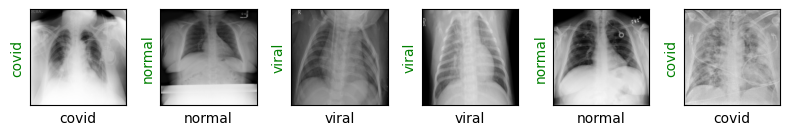

Evaluating at step 500
Val loss: 0.1877, Acc: 0.9417


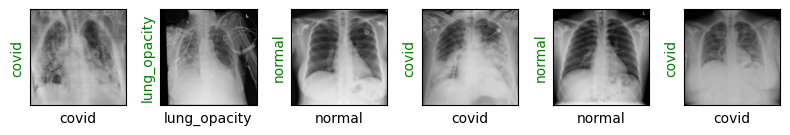

Evaluating at step 520
Val loss: 0.2819, Acc: 0.8833


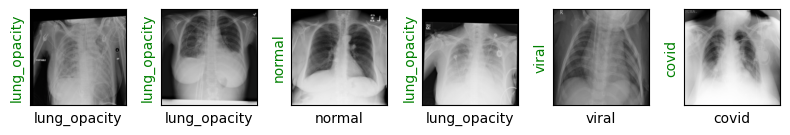

Evaluating at step 540
Val loss: 0.3004, Acc: 0.8833


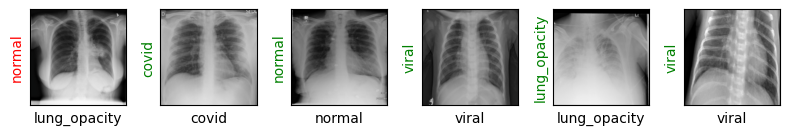

Evaluating at step 560
Val loss: 0.1927, Acc: 0.9750


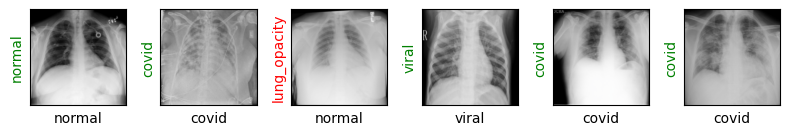

Evaluating at step 580
Val loss: 0.2073, Acc: 0.9417


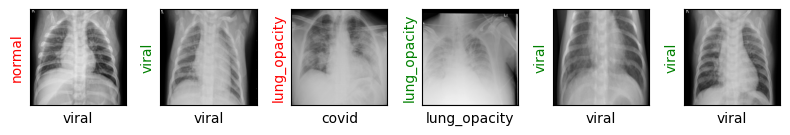

Evaluating at step 600
Val loss: 0.1747, Acc: 0.9667


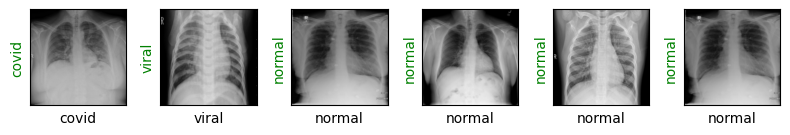

Evaluating at step 620
Val loss: 0.1426, Acc: 0.9833


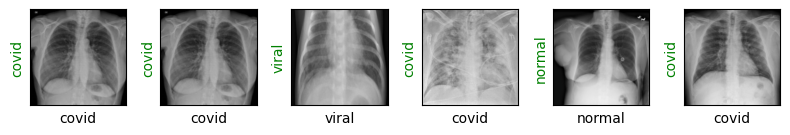

Performance condition satisfied..


In [21]:
train(epochs=10)

# Final Results

In [23]:
resnet18.eval()

correct = 0
total = 0
class_correct = [0] * 4
class_total = [0] * 4

with torch.no_grad():
    for images, labels in dl_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)

        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

        for i in range(labels.size(0)):
            label = labels[i]
            pred = preds[i]
            class_total[label] += 1
            if pred == label:
                class_correct[label] += 1

overall_acc = correct / total
print(f'\nOverall Test Accuracy: {overall_acc:.4f} ({correct}/{total})\n')

for i, class_name in enumerate(class_names):
    acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Class {class_name:15s} — Accuracy: {acc:.4f} ({class_correct[i]}/{class_total[i]})')


Overall Test Accuracy: 0.9583 (115/120)

Class normal          — Accuracy: 0.9429 (33/35)
Class viral           — Accuracy: 0.9355 (29/31)
Class covid           — Accuracy: 1.0000 (29/29)
Class lung_opacity    — Accuracy: 0.9600 (24/25)


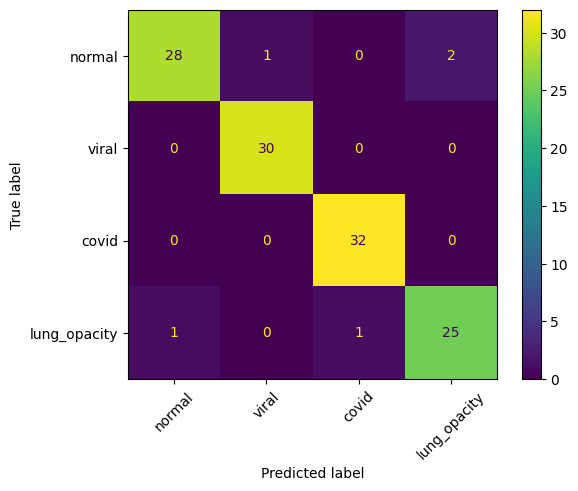

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dl_test:
        images = images.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.show()